In [1]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
from moviepy.editor import *
from utils.utils import *
from utils.Line import Line

%matplotlib inline

### Load calibration coefficients

In [2]:
coeff = pickle.load( open( "camera_cal/coefficients.p", "rb" ) )
mtx = coeff['mtx']
dist = coeff['dist']

### Load video frames

In [3]:
left_lane = Line()
right_lane = Line()

In [6]:
video_file = "test_videos/harder_challenge_video.mp4"
video = VideoFileClip(video_file)
a = video.iter_frames()

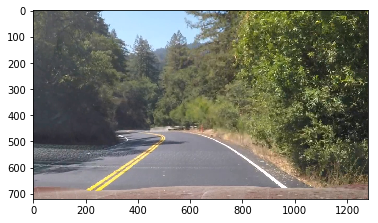

In [14]:
for i in range(10):
    frame = next(a)
plt.imshow(frame)

True
286.419939541 m 979.46892362 m
True


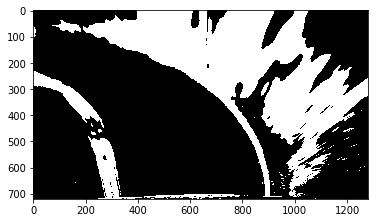

In [15]:
undistorted, thresholded, top_down = process_frame(frame,mtx,dist)

plt.imshow(thresholded, cmap='gray')
print(left_lane.detected and right_lane.detected)

if left_lane.detected and right_lane.detected:
    left_fit, right_fit, left_curverad, right_curverad = get_poly_from_last(thresholded, left_lane.current_fit, right_lane.current_fit)
else:
    left_base, right_base = find_lanes_hist(thresholded)
    left_fit, right_fit, left_curverad, right_curverad, out_img = get_polynomial(thresholded, left_base, right_base)
    
print(left_curverad, 'm', right_curverad, 'm')

# Generate x and y values for plotting
ploty = np.linspace(0, top_down.shape[0]-1, top_down.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

is_valid = sanity_check(left_fitx, right_fitx, left_curverad, right_curverad)
print(is_valid)

left_lane.add_stats(is_valid, left_fit, 0, 0)
right_lane.add_stats(is_valid, right_fit,0,0)

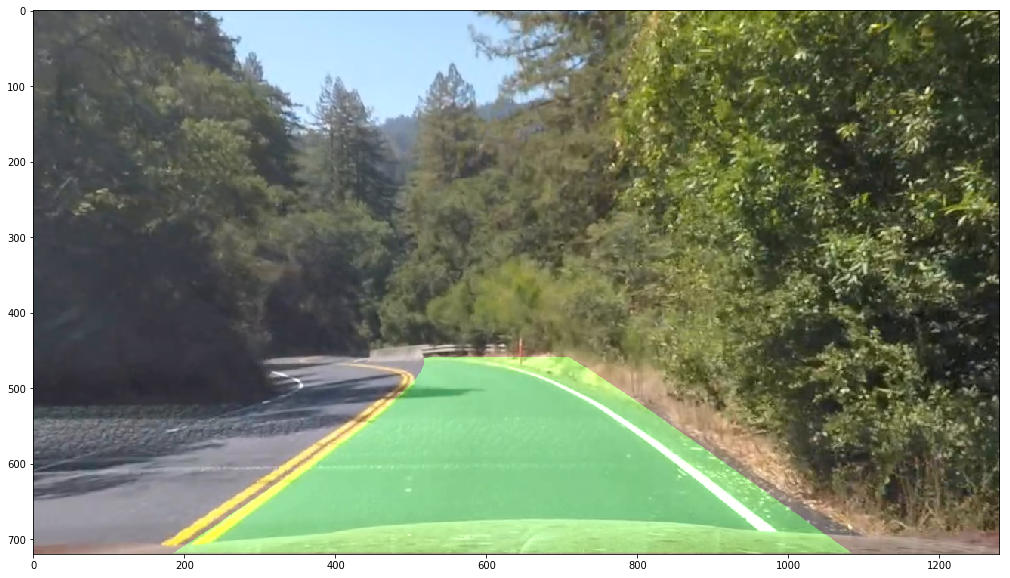

In [16]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(thresholded).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

ploty = np.linspace(0, thresholded.shape[0]-1, thresholded.shape[0] )
left_best_fit = left_lane.get_best_fit()[0]
right_best_fit = right_lane.get_best_fit()[0]

if left_best_fit is not None and right_best_fit is not None:
    left_fitx = left_best_fit[0]*ploty**2 + left_best_fit[1]*ploty + left_best_fit[2]
    right_fitx = right_best_fit[0]*ploty**2 + right_best_fit[1]*ploty + right_best_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = get_inverse_transform(color_warp)
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

else:
    result = undistorted

plt.figure(figsize=(20,10))
plt.imshow(result)

In [4]:
def process_image(image):
    undistorted, thresholded, top_down = process_frame(image,mtx,dist)
    #plt.imshow(top_down, cmap='gray')
    if left_lane.detected and right_lane.detected:
        left_fit, right_fit, left_curverad, right_curverad = get_poly_from_last(thresholded, left_lane.current_fit, right_lane.current_fit)
    else:
        left_base, right_base = find_lanes_hist(thresholded)
        left_fit, right_fit, left_curverad, right_curverad, out_img = get_polynomial(thresholded, left_base, right_base)

    # Generate x and y values for plotting
    ploty = np.linspace(0, thresholded.shape[0]-1, thresholded.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    dist_to_center = find_position(thresholded.shape[1], left_fitx[-1], right_fitx[-1])
    is_valid = sanity_check(left_fitx, right_fitx, left_curverad, right_curverad)
    #print(is_valid)
    left_lane.add_stats(is_valid, left_fit, left_curverad, dist_to_center)
    right_lane.add_stats(is_valid, right_fit, right_curverad, dist_to_center)
        
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(thresholded).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, thresholded.shape[0]-1, thresholded.shape[0] )
    left_stats = left_lane.get_best_fit()
    right_stats = right_lane.get_best_fit()

    if left_stats is not None and right_stats is not None:
        left_best_fit = left_stats[0]
        right_best_fit = right_stats[0]
        
        left_fitx = left_best_fit[0]*ploty**2 + left_best_fit[1]*ploty + left_best_fit[2]
        right_fitx = right_best_fit[0]*ploty**2 + right_best_fit[1]*ploty + right_best_fit[2]

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = get_inverse_transform(color_warp)
        # Combine the result with the original image
        result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
        
        # Put text on an image
        font = cv2.FONT_HERSHEY_SIMPLEX
        curvature = (left_stats[1] + right_stats[1])/2
        text = "Radius of Curvature: {} m".format(int(curvature))
        cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
        
        position = left_stats[2]
        if position < 0:
            text = "Vehicle is {:.2f} m left of center".format(-position)
        else:
            text = "Vehicle is {:.2f} m right of center".format(position)
        cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)

    else:
        result = undistorted

    return result

In [5]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

video_file = "test_videos/project_video.mp4"
white_output = 'test_videos/test_project_video.mp4'
clip1 = VideoFileClip(video_file)
#clip1 = VideoFileClip(video_file).subclip(0,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos/test_project_video.mp4
[MoviePy] Writing video test_videos/test_project_video.mp4


100%|█████████▉| 1260/1261 [04:28<00:00,  4.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/test_project_video.mp4 

CPU times: user 6min 4s, sys: 1min 4s, total: 7min 9s
Wall time: 4min 29s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))
